In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [10]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip'
dataset_path = 'UCI HAR Dataset'

# Unzip the dataset
import zipfile
import urllib.request
import os

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, 'UCI_HAR_Dataset.zip')
    with zipfile.ZipFile('UCI_HAR_Dataset.zip', 'r') as zip_ref:
        zip_ref.extractall('.')


In [18]:
# Load the dataset
train_data = pd.read_csv(f'{dataset_path}/train/X_train.txt', delim_whitespace=True, header=None)
test_data = pd.read_csv(f'{dataset_path}/test/X_test.txt', delim_whitespace=True, header=None)
data = pd.concat([train_data, test_data])

# Normalize the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Apply DBSCAN
dbscan = DBSCAN(eps=50, min_samples=10)
clusters = dbscan.fit_predict(data_scaled)

# Display the original output of DBSCAN
print("Cluster labels for each point in the dataset:")
print(clusters)

unique, counts = np.unique(clusters, return_counts=True)
cluster_counts = dict(zip(unique, counts))
print("\nNumber of points in each cluster:")
print(cluster_counts)

# Adding the cluster labels to the dataframe
data['cluster'] = clusters


Cluster labels for each point in the dataset:
[0 0 0 ... 0 0 0]

Number of points in each cluster:
{-1: 2, 0: 10297}


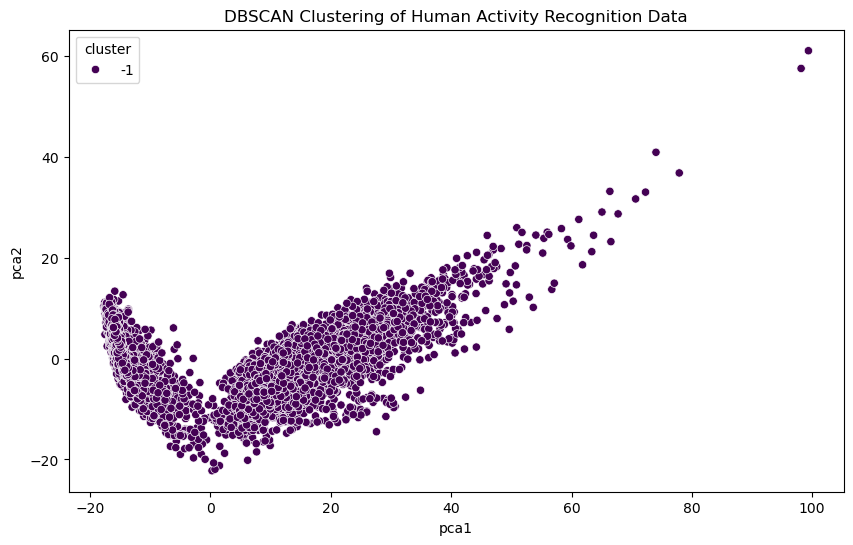

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
data_pca = pd.DataFrame(data_pca, columns=['pca1', 'pca2'])
data_pca['cluster'] = clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_pca, x='pca1', y='pca2', hue='cluster', palette='viridis', legend='full')
plt.title('DBSCAN Clustering of Human Activity Recognition Data')
plt.show()